<a href="https://colab.research.google.com/github/szdziedzic/ai-course-project/blob/main/flight_prices_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight prices predictor

The goal of this project is to train couple of machine learning models to predict flight prices based on [this](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?resource=download) dataset and compare the results which they were able to achieve.

First let's load and analyze the dataset

In [136]:
import pandas as pd
import numpy as np

In [137]:
data = pd.read_csv('flights_data.csv', index_col=0).sample(5000)

In [138]:
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
174189,Indigo,6E-425,Hyderabad,Afternoon,one,Night,Kolkata,Economy,6.17,31,9543
53848,Indigo,6E-5332,Mumbai,Early_Morning,one,Afternoon,Bangalore,Economy,6.92,8,6930
143444,Indigo,6E-6172,Kolkata,Night,zero,Late_Night,Hyderabad,Economy,2.17,11,6489
126664,Air_India,AI-573,Kolkata,Evening,one,Afternoon,Delhi,Economy,18.75,44,11260
118619,AirAsia,I5-1228,Bangalore,Early_Morning,zero,Morning,Chennai,Economy,1.00,38,1603


In [139]:
data.shape

(5000, 11)

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 174189 to 168770
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           5000 non-null   object 
 1   flight            5000 non-null   object 
 2   source_city       5000 non-null   object 
 3   departure_time    5000 non-null   object 
 4   stops             5000 non-null   object 
 5   arrival_time      5000 non-null   object 
 6   destination_city  5000 non-null   object 
 7   class             5000 non-null   object 
 8   duration          5000 non-null   float64
 9   days_left         5000 non-null   int64  
 10  price             5000 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 468.8+ KB


According to kaggle website asociated with dataset linked above we can see what each of the columns mean:
```
1) Airline: The name of the airline company is stored in the airline column.
2) Flight: Flight stores information regarding the plane's flight code.
3) Source City: City from which the flight takes off.
4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time.
5) Stops: Stores the number of stops between the source and destination cities.
6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. Keeps information about the arrival time.
7) Destination City: City where the flight will land.
8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10)Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11) Price: Target variable stores information of the ticket price.
```

In [141]:
for col in data.columns:
  print(f"Column: {col}")
  print(data[col].value_counts())
  print(f"Number of null values: {data[col].isnull().sum()}")
  print(f"Number of unique values in column: {data[col].nunique()}")
  print()

Column: airline
Vistara      2088
Air_India    1388
Indigo        726
GO_FIRST      359
AirAsia       288
SpiceJet      151
Name: airline, dtype: int64
Number of null values: 0
Number of unique values in column: 6

Column: flight
UK-772     51
UK-826     51
UK-878     46
UK-720     45
UK-822     43
           ..
G8-422      1
6E-6513     1
6E-6215     1
6E-268      1
6E-2616     1
Name: flight, Length: 932, dtype: int64
Number of null values: 0
Number of unique values in column: 932

Column: source_city
Delhi        1060
Mumbai        996
Bangalore     894
Kolkata       786
Hyderabad     644
Chennai       620
Name: source_city, dtype: int64
Number of null values: 0
Number of unique values in column: 6

Column: departure_time
Morning          1157
Evening          1105
Early_Morning    1089
Night             830
Afternoon         803
Late_Night         16
Name: departure_time, dtype: int64
Number of null values: 0
Number of unique values in column: 6

Column: stops
one            4132
z

As we can see non of the columns have any missing data so it looks like dataset is pretty clean.

Let's analyze data in each column:
- `airline`: this column contains categorical data with 6 unique values
- `flight`:  this column contains categorical data with 1561 unique values
- `source_city`: this column contains categorical data with 6 unique values
- `departure_time`: this column contains categorical data with 6 unique values
- `stops`: this column contains categorical data with 3 unique values
- `arrival_time`: this column contains categorical data with 6 unique values
- `destination_city`: this column contains categorical data with 6 unique values
- `class`: this column contains categorical data with 2 unique values
- `durration`: this is numerical feature
- `price`: this is numerical feature
- `days_left`: this is numerical feature

In [142]:
import matplotlib.pyplot as plt

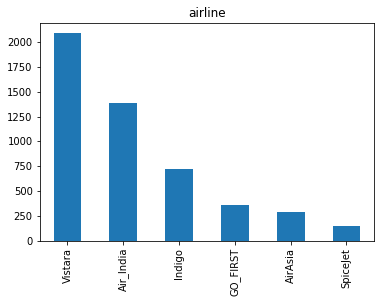

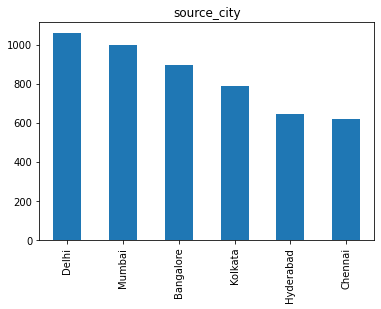

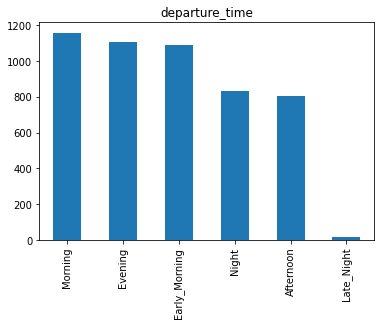

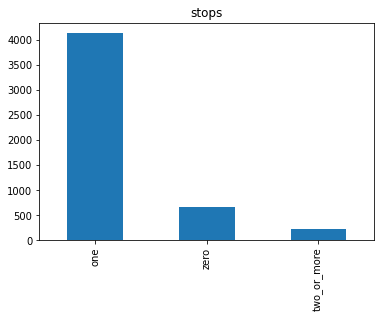

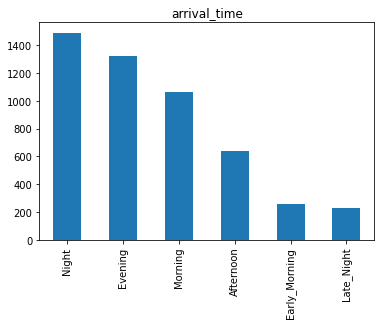

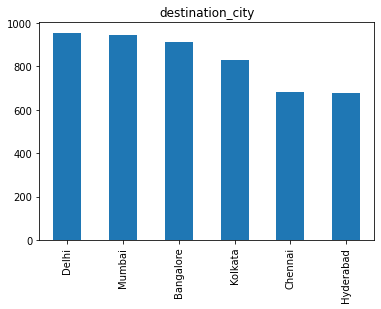

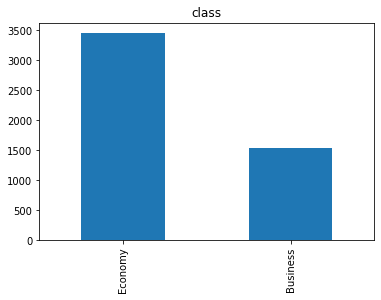

In [143]:
for col in ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class"]:
  data[col].value_counts().plot(kind="bar", title=col)
  plt.show()
  print()

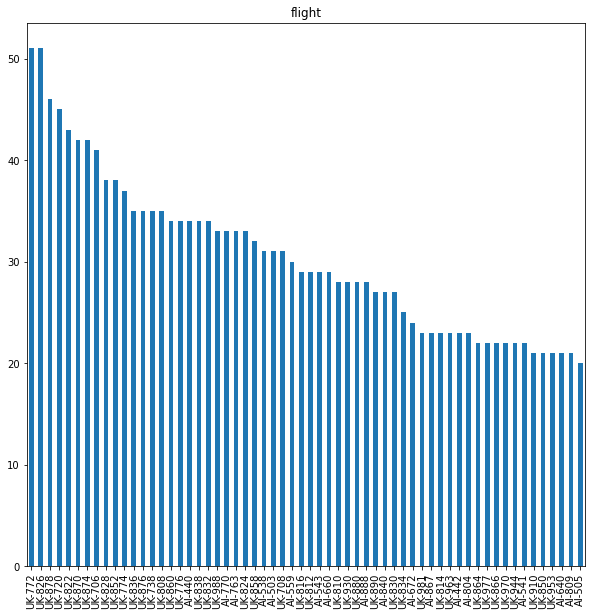

In [144]:
data["flight"].value_counts().nlargest(60).plot(kind="bar", title="flight", figsize=(10, 10))
plt.show()

We have ton of categories in `flight` column. Let's try to limit this number

In [145]:
flight_value_counts = data["flight"].value_counts()
values_to_be_squashed = []
for value in flight_value_counts.keys():
  # set flight category for those which occure less then 100 times to OTHER
  # to limit number of categories
  if flight_value_counts[value] < 20:
    values_to_be_squashed.append(value)
print(len(values_to_be_squashed))

869


In [146]:
data["flight"] = data["flight"].replace(values_to_be_squashed, "OTHER")

print(data["flight"].value_counts())

OTHER     3116
UK-772      51
UK-826      51
UK-878      46
UK-720      45
          ... 
AI-809      21
AI-430      20
UK-955      20
AI-507      20
AI-505      20
Name: flight, Length: 64, dtype: int64


We don't have any missing data in columns and we don't have columns which only have one value, so fortunately we can skip step of fixing it.

Let's make sure that all of the values in our columns are represented by numbers instead of the text

In [12]:
print("Data types and their frequency:")
data.dtypes.value_counts()

Data types and their frequency:


object     8
int64      2
float64    1
dtype: int64

We have 8 columns containing text values, let's change it

Data in `airline`, `flight`, `source_city` and `destination_city` is unordered data, so let's use `get_dummies` method to create separate column for each of the values in these columns

In [13]:
unordered_data_columns = ["airline", "flight", "source_city", "destination_city"]
dummy_df = pd.get_dummies(data[unordered_data_columns])
dummy_df.head()

,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_AI-430,flight_AI-440,flight_AI-442,flight_AI-501,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
259119,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
196329,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83816,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
61408,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
25662,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [14]:
data = pd.concat([data, dummy_df], axis=1)
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
259119,Vistara,OTHER,Bangalore,Afternoon,two_or_more,Evening,Chennai,Business,31.17,5,...,0,0,0,0,0,1,0,0,0,0
196329,Vistara,UK-824,Chennai,Night,one,Early_Morning,Bangalore,Economy,11.33,33,...,0,0,0,0,1,0,0,0,0,0
83816,Indigo,OTHER,Mumbai,Afternoon,one,Night,Chennai,Economy,6.08,48,...,0,0,0,1,0,1,0,0,0,0
61408,Indigo,OTHER,Mumbai,Evening,one,Late_Night,Bangalore,Economy,8.08,49,...,0,0,0,1,1,0,0,0,0,0
25662,AirAsia,OTHER,Delhi,Night,one,Morning,Kolkata,Economy,12.25,33,...,1,0,0,0,0,0,0,0,1,0


Let's drop old columns

In [15]:
data = data.drop(unordered_data_columns, axis=1)

In [16]:
data.head()

,departure_time,stops,arrival_time,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
259119,Afternoon,two_or_more,Evening,Business,31.17,5,59106,0,0,0,...,0,0,0,0,0,1,0,0,0,0
196329,Night,one,Early_Morning,Economy,11.33,33,4755,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83816,Afternoon,one,Night,Economy,6.08,48,1890,0,0,0,...,0,0,0,1,0,1,0,0,0,0
61408,Evening,one,Late_Night,Economy,8.08,49,2124,0,0,0,...,0,0,0,1,1,0,0,0,0,0
25662,Night,one,Morning,Economy,12.25,33,2480,1,0,0,...,1,0,0,0,0,0,0,0,1,0


Now let's focus on categorical columns with ordered data like `departure_time`, `stops`, `arrival_time` and `class`. We can change data in these columns into numerical type using the data's order.

In [17]:
mapping_dict = {
    "departure_time": {
        "Early_Morning": 1,
        "Morning": 2,
        "Afternoon": 3,
        "Evening": 4,
        "Night": 5,
        "Late_Night": 6,
    },
    "stops": {
        "zero": 0,
        "one": 1,
        "two_or_more": 2
    },
    "arrival_time": {
        "Early_Morning": 1,
        "Morning": 2,
        "Afternoon": 3,
        "Evening": 4,
        "Night": 5,
        "Late_Night": 6,
    },
    "class": {
         "Economy": 1,
         "Business": 2
    }
}
data = data.replace(mapping_dict)
data[["departure_time","stops", "arrival_time", "class"]].head()

,departure_time,stops,arrival_time,class
259119,3,2,4,2
196329,5,1,1,1
83816,3,1,5,1
61408,4,1,6,1
25662,5,1,2,1


In [18]:
print("Data types and their frequency:")
data.dtypes.value_counts()

Data types and their frequency:


uint8      86
int64       6
float64     1
dtype: int64

Column: departure_time
2    1206
4    1130
1    1082
3     820
5     747
6      15
Name: departure_time, dtype: int64


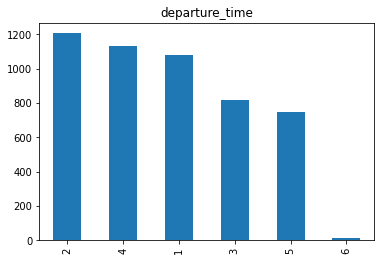


Column: stops
1    4206
0     568
2     226
Name: stops, dtype: int64


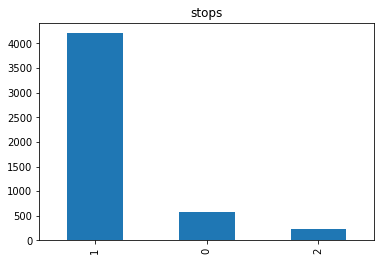


Column: arrival_time
5    1596
4    1355
2     996
3     602
1     248
6     203
Name: arrival_time, dtype: int64


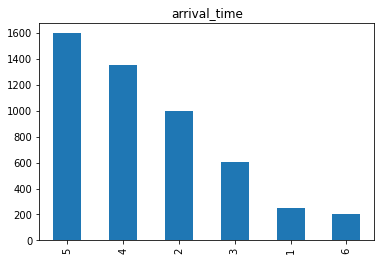


Column: class
1    3441
2    1559
Name: class, dtype: int64


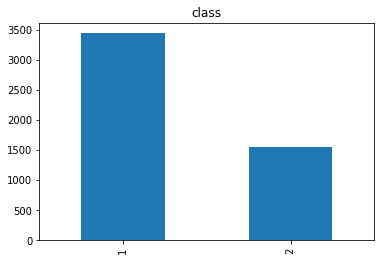

In [19]:
for col in ["departure_time", "stops", "arrival_time", "class"]:
  print(f"Column: {col}")
  print(data[col].value_counts())
  data[col].value_counts().plot(kind="bar", title=col)
  plt.show()
  print()

Now we have successfully converted all of the columns into numerical type data. Let's save the data.

In [20]:
data.head()

,departure_time,stops,arrival_time,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
259119,3,2,4,2,31.17,5,59106,0,0,0,...,0,0,0,0,0,1,0,0,0,0
196329,5,1,1,1,11.33,33,4755,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83816,3,1,5,1,6.08,48,1890,0,0,0,...,0,0,0,1,0,1,0,0,0,0
61408,4,1,6,1,8.08,49,2124,0,0,0,...,0,0,0,1,1,0,0,0,0,0
25662,5,1,2,1,12.25,33,2480,1,0,0,...,1,0,0,0,0,0,0,0,1,0


In [21]:
# data.to_csv("cleaned_flights_data.csv", index=True)

Let's divide our data into test and train set

In [22]:
from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != "price"]
y = data["price"] # price is the feature we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
X_train.head()

,departure_time,stops,arrival_time,class,duration,days_left,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
31998,2,1,5,1,12.08,26,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
35324,1,1,5,1,14.92,49,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
239849,3,1,2,2,17.92,27,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
58673,5,1,2,1,9.25,34,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
265281,2,1,4,2,7.42,20,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [24]:
X_train.shape

(3350, 92)

In [25]:
y_train.head()

31998      6172
35324      5657
239849    58125
58673      3944
265281    62591
Name: price, dtype: int64

In [26]:
y_train.shape

(3350,)

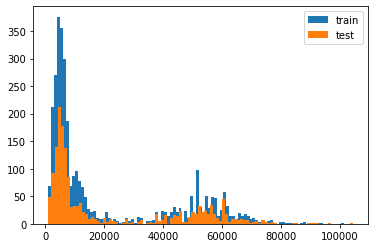

In [27]:
plt.hist(y_train, label="train", bins=100)
plt.hist(y_test, label="test", bins=100)
plt.legend()
plt.show()

# Models

We will use these models to predict flight price:

- `LinearRegression`
- `Ridge`
- `Lasso`
- `ElasticNet`
- `RandomForestRegressor`
- `NeuralNet`

For most of them we will run `GridSearch` with `StratifiedKFold` to find the best possible parameters and we will calculate metrics so we can select the best one for our purpose.



In [28]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

linear_regression_grid = GridSearchCV(
    make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    param_grid={'polynomialfeatures__degree': [1, 2, 3]},
    cv=kfold
)

linear_regression_grid.fit(X_train, y_train)
print(linear_regression_grid.best_params_)
print(linear_regression_grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


{'polynomialfeatures__degree': 1}
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])


In [42]:
from sklearn import metrics

linear_regression_metrics = {
  "model": "LinearRegression",
  "r2": metrics.r2_score(y_test, linear_regression_grid.best_estimator_.predict(X_test)),
  "explained_variance_score": metrics.explained_variance_score(y_test, linear_regression_grid.best_estimator_.predict(X_test)),
  "median_absolute_error": metrics.median_absolute_error(y_test, linear_regression_grid.best_estimator_.predict(X_test)),
  "mean_squared_error": metrics.mean_squared_error(y_test, linear_regression_grid.best_estimator_.predict(X_test)),
  "mean_absolute_error": metrics.mean_absolute_error(y_test, linear_regression_grid.best_estimator_.predict(X_test))
}
print(linear_regression_metrics)

{'model': 'LinearRegression', 'r2': 0.9160382147256467, 'explained_variance_score': 0.9160415811729246, 'median_absolute_error': 3085.459844134508, 'mean_squared_error': 44210534.54936843, 'mean_absolute_error': 4472.865541723537}


In [32]:
from sklearn.linear_model import Ridge

ridge_regression_grid = GridSearchCV(
    make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1)),
    param_grid={
        'polynomialfeatures__degree': [1, 2, 3],
        'ridge__alpha': [0.01, 0.1, 1, 10]
    },
    cv=kfold
)

ridge_regression_grid.fit(X_train, y_train)
print(ridge_regression_grid.best_params_)
print(ridge_regression_grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=10))])


In [43]:
ridge_regression_metrics = {
  "model": "Ridge",
  "r2": metrics.r2_score(y_test, ridge_regression_grid.best_estimator_.predict(X_test)),
  "explained_variance_score": metrics.explained_variance_score(y_test, ridge_regression_grid.best_estimator_.predict(X_test)),
  "median_absolute_error": metrics.median_absolute_error(y_test, ridge_regression_grid.best_estimator_.predict(X_test)),
  "mean_squared_error": metrics.mean_squared_error(y_test, ridge_regression_grid.best_estimator_.predict(X_test)),
  "mean_absolute_error": metrics.mean_absolute_error(y_test, ridge_regression_grid.best_estimator_.predict(X_test))
}
print(ridge_regression_metrics)

{'model': 'Ridge', 'r2': 0.9509416739954394, 'explained_variance_score': 0.9509442868767721, 'median_absolute_error': 2074.98135639712, 'mean_squared_error': 25831928.295375485, 'mean_absolute_error': 3340.4113236271337}


In [34]:
from sklearn.linear_model import Lasso

lasso_regression_grid = GridSearchCV(
    make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1)),
    param_grid={
        'polynomialfeatures__degree': [1, 2, 3],
        'lasso__alpha': [0.01, 0.1, 1, 10]
    },
    cv=kfold
)

lasso_regression_grid.fit(X_train, y_train)
print(lasso_regression_grid.best_params_)
print(lasso_regression_grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.202e+10, tolerance: 1.372e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+10, tolerance: 1.370e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coord

{'lasso__alpha': 10, 'polynomialfeatures__degree': 2}
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=10))])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e+10, tolerance: 1.711e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [44]:
lasso_regression_metrics = {
  "model": "Lasso",
  "r2": metrics.r2_score(y_test, lasso_regression_grid.best_estimator_.predict(X_test)),
  "explained_variance_score": metrics.explained_variance_score(y_test, lasso_regression_grid.best_estimator_.predict(X_test)),
  "median_absolute_error": metrics.median_absolute_error(y_test, lasso_regression_grid.best_estimator_.predict(X_test)),
  "mean_squared_error": metrics.mean_squared_error(y_test, lasso_regression_grid.best_estimator_.predict(X_test)),
  "mean_absolute_error": metrics.mean_absolute_error(y_test, lasso_regression_grid.best_estimator_.predict(X_test))
}
print(lasso_regression_metrics)

{'model': 'Lasso', 'r2': 0.9508543173595588, 'explained_variance_score': 0.9508569372789, 'median_absolute_error': 1968.0921339186807, 'mean_squared_error': 25877926.4069699, 'mean_absolute_error': 3288.615894755378}


In [37]:
from sklearn.linear_model import ElasticNet

elastic_net_regression_grid = GridSearchCV(
    make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1)),
    param_grid={
        'polynomialfeatures__degree': [1, 2, 3],
        'elasticnet__alpha': [0.01, 0.1, 1, 10]
    },
    cv=kfold
)

elastic_net_regression_grid.fit(X_train, y_train)
print(elastic_net_regression_grid.best_params_)
print(elastic_net_regression_grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.861e+10, tolerance: 1.372e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.811e+10, tolerance: 1.370e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coord

{'elasticnet__alpha': 0.01, 'polynomialfeatures__degree': 2}
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet', ElasticNet(alpha=0.01))])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.677e+10, tolerance: 1.711e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [45]:
elastic_net_regression_metrics = {
  "model": "ElasticNet",
  "r2": metrics.r2_score(y_test, elastic_net_regression_grid.best_estimator_.predict(X_test)),
  "explained_variance_score": metrics.explained_variance_score(y_test, elastic_net_regression_grid.best_estimator_.predict(X_test)),
  "median_absolute_error": metrics.median_absolute_error(y_test, elastic_net_regression_grid.best_estimator_.predict(X_test)),
  "mean_squared_error": metrics.mean_squared_error(y_test, elastic_net_regression_grid.best_estimator_.predict(X_test)),
  "mean_absolute_error": metrics.mean_absolute_error(y_test, elastic_net_regression_grid.best_estimator_.predict(X_test))
}
print(elastic_net_regression_metrics)

{'model': 'ElasticNet', 'r2': 0.9501586239934668, 'explained_variance_score': 0.9501595318659996, 'median_absolute_error': 2081.7615508424105, 'mean_squared_error': 26244247.531477604, 'mean_absolute_error': 3376.7716184216824}


In [152]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regression_grid = GridSearchCV(
    RandomForestRegressor(),
    param_grid={
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [1, 10, 20, 30, 40]
    },
    cv=kfold
)

random_forest_regression_grid.fit(X_train, y_train)
print(random_forest_regression_grid.best_params_)
print(random_forest_regression_grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


{'max_depth': 40, 'n_estimators': 300}
RandomForestRegressor(max_depth=40, n_estimators=300)


In [153]:
random_forest_regression_metrics = {
  "model": "RandomForestRegressor",
  "r2": metrics.r2_score(y_test, random_forest_regression_grid.best_estimator_.predict(X_test)),
  "explained_variance_score": metrics.explained_variance_score(y_test, random_forest_regression_grid.best_estimator_.predict(X_test)),
  "median_absolute_error": metrics.median_absolute_error(y_test, random_forest_regression_grid.best_estimator_.predict(X_test)),
  "mean_squared_error": metrics.mean_squared_error(y_test, random_forest_regression_grid.best_estimator_.predict(X_test)),
  "mean_absolute_error": metrics.mean_absolute_error(y_test, random_forest_regression_grid.best_estimator_.predict(X_test))
}
print(random_forest_regression_metrics)

{'model': 'RandomForestRegressor', 'r2': 0.9619021271795319, 'explained_variance_score': 0.9619706781637782, 'median_absolute_error': 1106.025, 'mean_squared_error': 20060642.077619575, 'mean_absolute_error': 2539.973568116185}


In [46]:
import tensorflow as tf
from tensorflow import keras

In [109]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.callbacks import History

history = History()
neural_net = Sequential()
neural_net.add(Dense(300,activation="relu",input_shape=(X_train.shape[1],)))
neural_net.add(Dropout(0.4))
neural_net.add(Dense(150,activation="relu"))
neural_net.add(Dropout(0.4))
neural_net.add(Dense(30,activation="relu"))
neural_net.add(Dropout(0.4))
neural_net.add(Dense(1,activation="relu"))
neural_net.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 300)               27900     
                                                                 
 dropout_33 (Dropout)        (None, 300)               0         
                                                                 
 dense_71 (Dense)            (None, 150)               45150     
                                                                 
 dropout_34 (Dropout)        (None, 150)               0         
                                                                 
 dense_72 (Dense)            (None, 30)                4530      
                                                                 
 dropout_35 (Dropout)        (None, 30)                0         
                                                                 
 dense_73 (Dense)            (None, 1)               

In [110]:
neural_net.compile(loss="mean_absolute_error",optimizer="Adam", metrics=["mean_absolute_error"])

In [111]:
history = neural_net.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1/150
105/105 [==============================] - 1s 6ms/step - loss: 19170.3340 - mean_absolute_error: 19170.3340 - val_loss: 17207.8438 - val_mean_absolute_error: 17207.8438
Epoch 2/150
105/105 [==============================] - 0s 4ms/step - loss: 16353.0840 - mean_absolute_error: 16353.0840 - val_loss: 16386.8555 - val_mean_absolute_error: 16386.8555
Epoch 3/150
105/105 [==============================] - 1s 5ms/step - loss: 15524.4570 - mean_absolute_error: 15524.4570 - val_loss: 15780.8545 - val_mean_absolute_error: 15780.8545
Epoch 4/150
105/105 [==============================] - 0s 5ms/step - loss: 15187.3438 - mean_absolute_error: 15187.3438 - val_loss: 15484.5576 - val_mean_absolute_error: 15484.5576
Epoch 5/150
105/105 [==============================] - 0s 5ms/step - loss: 14904.6074 - mean_absolute_error: 14904.6074 - val_loss: 15227.3486 - val_mean_absolute_error: 15227.3486
Epoch 6/150
105/105 [==============================] - 1s 6ms/step - loss: 14619.7646 - mean_ab

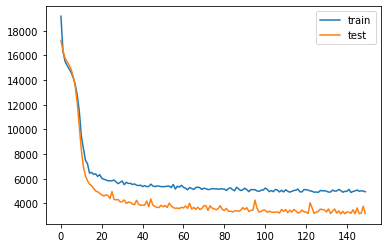

In [134]:
plt.plot(history.history['mean_absolute_error'], label = "train")
plt.plot(history.history['val_mean_absolute_error'], label = "test")


plt.legend()
plt.show()

In [112]:
neural_net_regression_metrics = {
  "model": "NeuralNet",
  "r2": metrics.r2_score(y_test, neural_net.predict(X_test)),
  "explained_variance_score": metrics.explained_variance_score(y_test, neural_net.predict(X_test)),
  "median_absolute_error": metrics.median_absolute_error(y_test, neural_net.predict(X_test)),
  "mean_squared_error": metrics.mean_squared_error(y_test, neural_net.predict(X_test)),
  "mean_absolute_error": metrics.mean_absolute_error(y_test, neural_net.predict(X_test))
}
print(neural_net_regression_metrics)

{'model': 'NeuralNet', 'r2': 0.9451438637702384, 'explained_variance_score': 0.9473213669873712, 'median_absolute_error': 1476.568359375, 'mean_squared_error': 28884796.793042213, 'mean_absolute_error': 3189.5306321762546}


In [154]:
model_metrics = pd.DataFrame(data=[linear_regression_metrics, lasso_regression_metrics, ridge_regression_metrics, elastic_net_regression_metrics, random_forest_regression_metrics, neural_net_regression_metrics])

In [155]:
model_metrics

,model,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LinearRegression,0.916038,0.916042,3085.459844,4.421053e+07,4472.865542
1,Lasso,0.950854,0.950857,1968.092134,2.587793e+07,3288.615895
2,Ridge,0.950942,0.950944,2074.981356,2.583193e+07,3340.411324
3,ElasticNet,0.950159,0.950160,2081.761551,2.624425e+07,3376.771618
4,RandomForestRegressor,0.961902,0.961971,1106.025000,2.006064e+07,2539.973568
5,NeuralNet,0.945144,0.947321,1476.568359,2.888480e+07,3189.530632


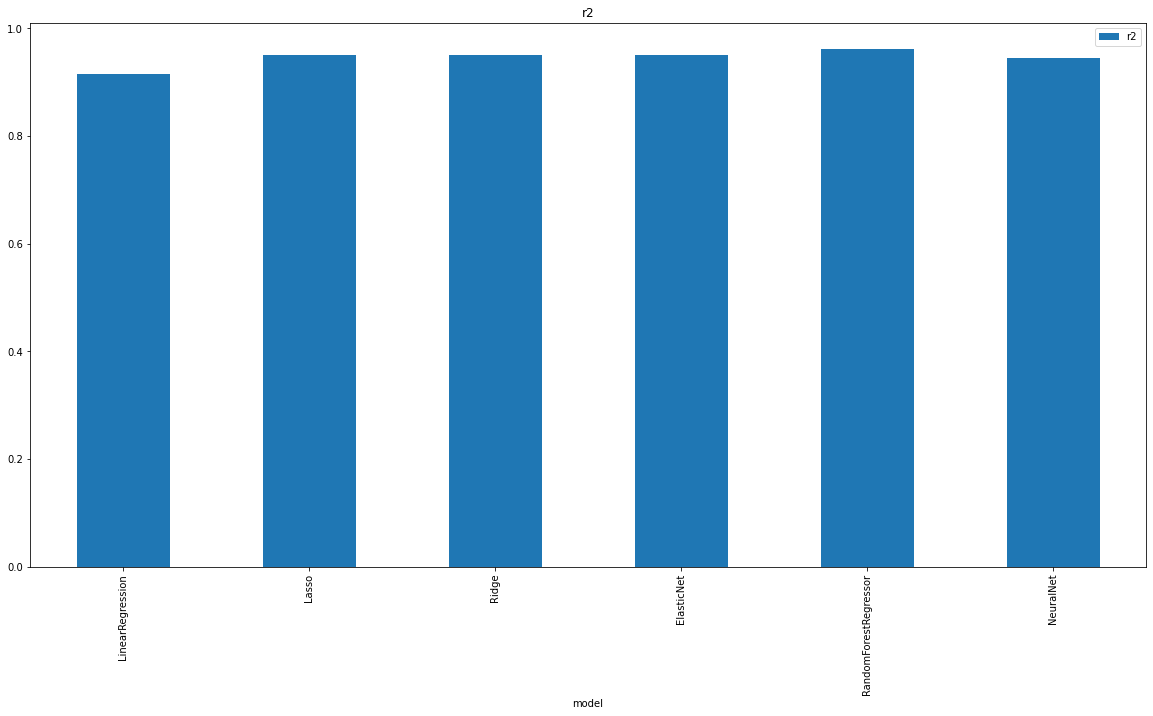

In [156]:
model_metrics.plot(kind="bar", title="r2", x="model", y="r2", figsize=(20, 10))

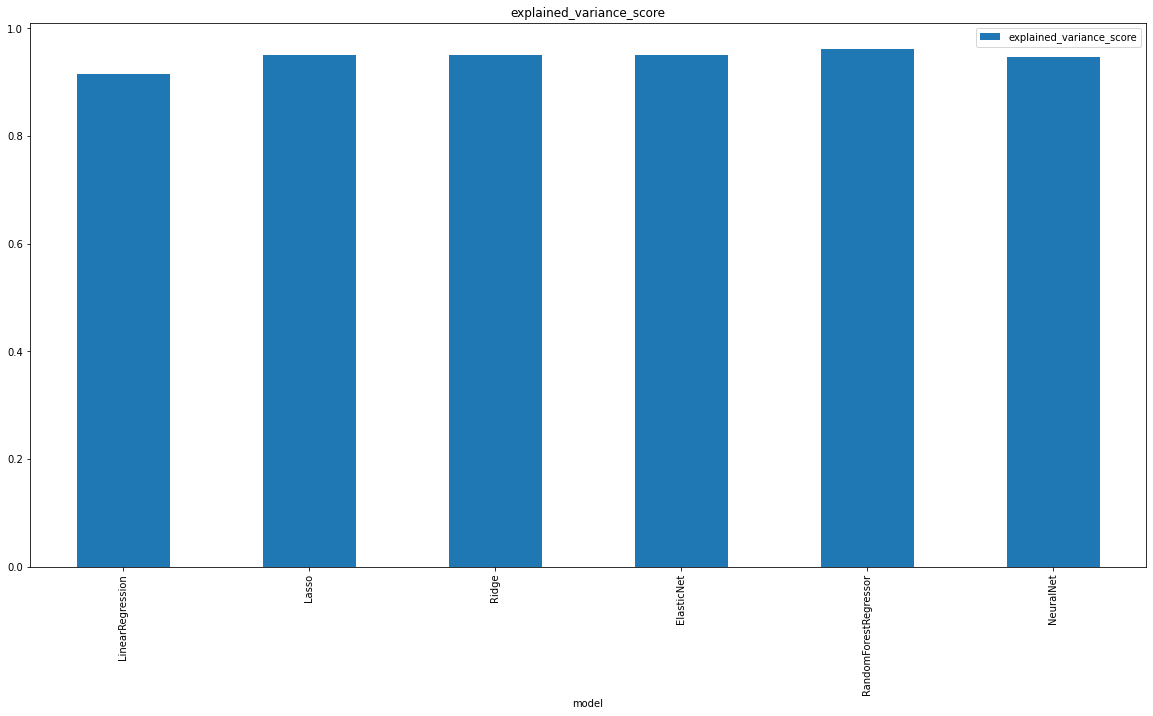

In [157]:
model_metrics.plot(kind="bar", title="explained_variance_score", x="model", y="explained_variance_score", figsize=(20, 10))

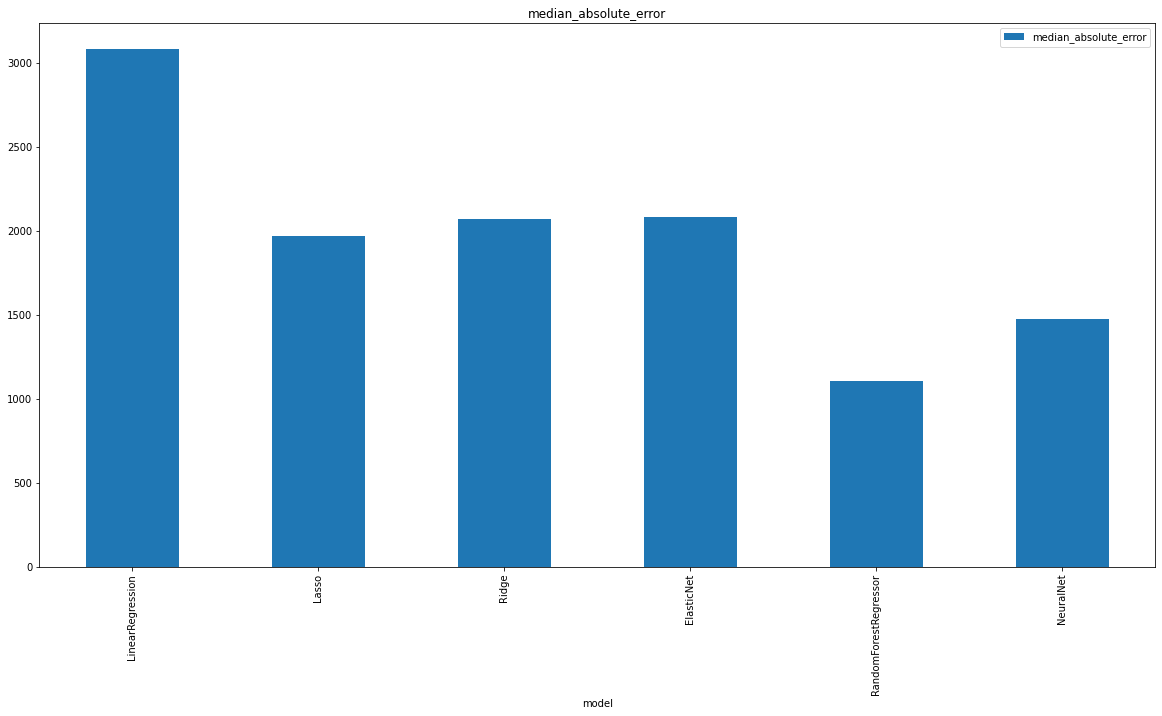

In [158]:
model_metrics.plot(kind="bar", title="median_absolute_error", x="model", y="median_absolute_error", figsize=(20, 10))

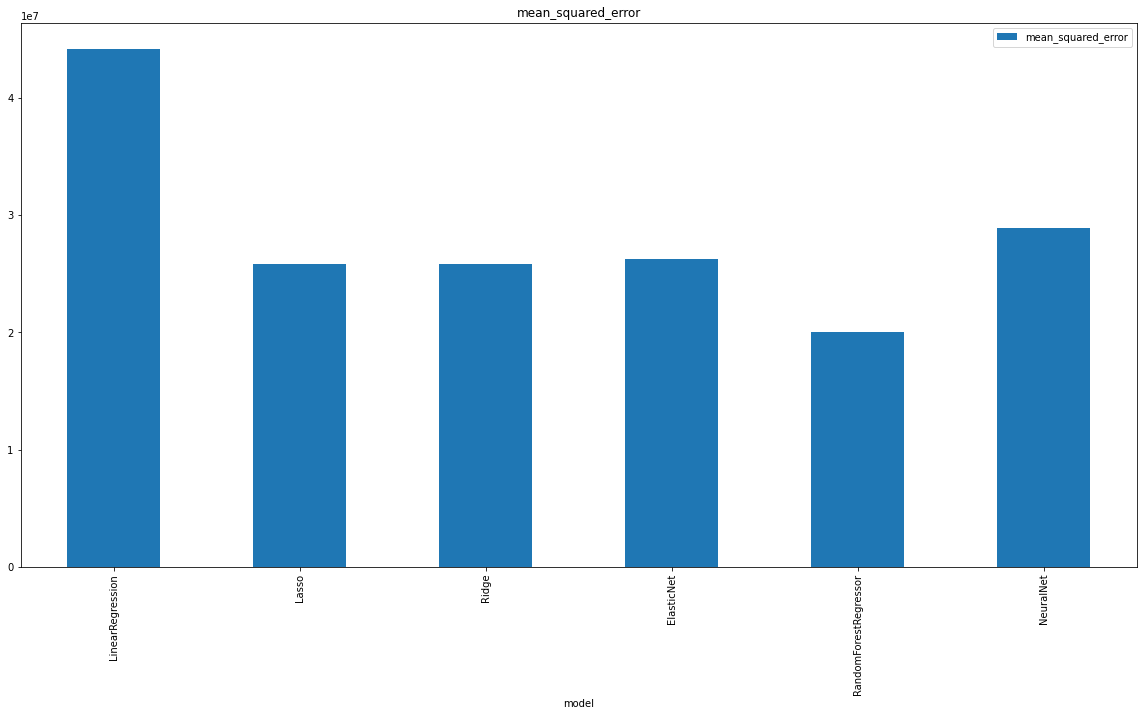

In [159]:
model_metrics.plot(kind="bar", title="mean_squared_error", x="model", y="mean_squared_error", figsize=(20, 10))

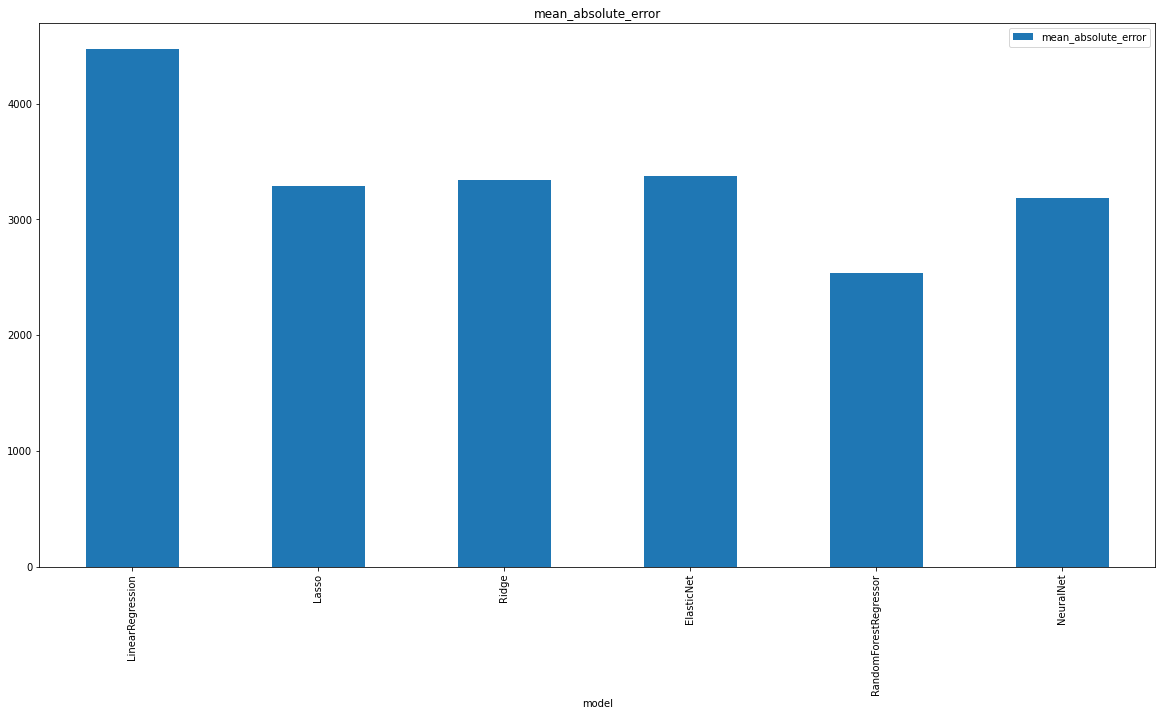

In [160]:
model_metrics.plot(kind="bar", title="mean_absolute_error", x="model", y="mean_absolute_error", figsize=(20, 10))

# Summary

As we can all of the models were able to achive really good results. Looking at the metrics I would say that `RandomForestRegressor` has got the best results out of all models.